## PART 4 - BASIC STOCK PRICE PREDICTION USING RNN 

Technical analysis is used to decide the most important factors that affect the stock and make a buy/sell decision. 

The entire procedure in this notebook consists of the following steps:

- Step 1 - Function to read data from file, prepare and extract required columns
- Step 2 - Function to normalize prepared data
- Step 3 - Function to convert data to time-series format.
- Step 4 - Function to build RNN - LSTM model
- Step 5 - Function to train RNN - LSTM model
- Step 6 - Function to predict prices from RNN - LSTM model
- Step 7 - Function to visualize results of RNN - LSTM model
- Step 8 - Function to evaluate RNN - LSTM model

### Results -  The predictive model was applied on the following stocks and analyzed

    1. Apple
    2. IBM
    3. Goldman Sachs
    4. Amazon
    5. General Electric
    6. Google <br>


In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
print(tf.__version__) #1.3.0
print(keras.__version__) #2.2.0
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.merge import concatenate, add
from keras.layers.recurrent import LSTM, GRU
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from sklearn.metrics import accuracy_score as acc
from scipy import stats
from keras.models import model_from_json

/Users/aishwaryagunashekar/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


1.5.1
2.2.2


The stock analysis was done on the following companies

- Apple
- IBM
- Goldman Sachs
- Amazon 
- General Electric
- Google 


The following steps have been taken in creating a predictive stock market model:

- Data preparation for time - series stock market model
- Building the model
- Training the model
- Predicting the stock prices 
- Evaluating the model
- Visualizing the model

### DATA PREPARATION FOR TIME-SERIES STOCK MARKET PREDICTIVE MODEL

#### 1. Function to read data from file, prepare and extract required columns

In [1]:
# Get rid of , in the Volume, then convert it to a float

def volume_to_float(volume_str):
    
    volume_str = str(volume_str)
    return float(volume_str.replace(",",""))


def data_preparation(data_path, columns_list):
    
    # Importing the training set
    dataset_original = pd.read_csv(data_path)
    dataset_original['Volume'] = dataset_original['Volume'].apply(volume_to_float)

    #Choose the columns to create training set
    # 1,6 refers to  the 2nd and 7th column with column indices(1 - CLOSE, 6 - EMA
    training_set = dataset_original.iloc[:, columns_list].values

    print("Shape of train set",np.shape(training_set))
    print("\nTrain dataset head\n")
    print(dataset_original.head(5))
    
    return training_set, dataset_original

#### 2. Function to normalize prepared data

In [3]:
def normalize_data(training_set):
    print("\n")
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    print(np.shape(training_set_scaled))
    print("\n")
    print(training_set_scaled)
    print("\n\n")
    return training_set_scaled, sc 

#### 3. Function to convert data to time-series format 


#####  Input shape of a 3D tensor
3D tensor with shape (batch_size, timesteps, input_dim)

This reshaping is necessary to add additional indicators over the OPEN stock price


Here we are using batchsize = whole dataset, timesteps = 60, and 1 additional indictor

In [4]:
# Creating a data structure with 120 timesteps and 1 output (We use the CLOSE prices here)
# Set X-train's columns to all the columns needed in the train data, in this example it's 0:2, CLOSE and VOLUME 
# y_train contains only the Target variable ( CLOSE price based on the previous no of timesteps)

def time_series_convert(training_set_scaled, no_timesteps, total_obs, target_column, input_features):
    X_train = []
    y_train = []
    for i in range(no_timesteps, total_obs):
        
        #120 prior rows and all the columns over those observations forms 1 observation 
        X_train.append(training_set_scaled[i - no_timesteps:i, 0:])
        
        #1 target of CLOSE PRICE Of next day 
        y_train.append(training_set_scaled[i, target_column])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    #Each of the 1390 observations will have 120 x 7 values and 1 target variable
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], input_features))
    print("X_train shape",X_train.shape)
    print("y_train shape",y_train.shape)
    print(pd.DataFrame(y_train).head())
    
    print("\n\n Checking 1 Observation \n")
    print(X_train[0], y_train[0])
    return X_train, y_train

### BUILD, TRAIN, TEST, EVALUATE AND VISUALIZE THE MODEL

Stock market is affected by a lot of factors and we need more of those factors to be captured by the neurons. Therefore we need an LSTM layer with high dimensionality. Choosing a low number of neurons will not capture the upward and downward trends properly. To get high dimensionality, we use a high number of neurons and high number of layers. 

Return Sequence is set to true when there is another LSTM layer following the current LSTM layer. 

We are using the mean_squared_error because we are doing some regression and predicting a continuous value. Even though the rms_prop optimizer is the recommended optimizer for Recurrent Neural Networks, through experimentation we find out that the Adam optimizer performs better on our implementation. It's very powerful and performs relevant weight updates

We are using the epochs = 100, because we notice that the loss converges for that many number of epochs. We also don't want to increase the epochs too much in a way that it overfits to the training data. We found this to be the optimal number of epochs that predict the stock price accurately


#### 4. Function to build RNN - LSTM model

In [5]:
def build_rnn_model(X_train, input_features):
    
    regressor = Sequential()
    
    # Adding the first LSTM layer and some Dropout regularisation
    # Three important paramaters - Number of units,  return sequences, input shape 
    regressor.add(LSTM(units = 120, return_sequences = True, input_shape = (X_train.shape[1], input_features)))
    regressor.add(Dropout(0.3))
    
    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 120, return_sequences = True))
    regressor.add(Dropout(0.3))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 120, return_sequences = True))
    regressor.add(Dropout(0.3))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 120, return_sequences = True))
    regressor.add(Dropout(0.3))

    # Adding a fifth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 120))
    regressor.add(Dropout(0.3))

    regressor.add(Dense(32, kernel_initializer="uniform",activation='relu'))        

    # Adding the output layer, we have one output value, that is output of only one dimension  
    # We are adding a fully connected output layer 
    regressor.add(Dense(units = 1))  
    
    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    print("regressor model built and compiled...")
    return regressor

#### 5. Function to train RNN - LSTM model


In [7]:
def train_model(regressor, X_train, y_train, epochs = 20):
    
    print("\ntraining started...")
    print(regressor.summary())
    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = 32, epochs = epochs, validation_split = 0.15, shuffle = True) 
    return regressor

#### 6. Function to predict prices from RNN - LSTM model


##### Important steps I took to ensure that we get relevant predictions 

-  As we know, the we are trying to predict stock prices for the month of January 2018, and our model is built in such a way that the input requires data of previous 60 financial days. 


-  And we know our test set contains values of only that month of January that is (20 days)


-  So we can NORMALIZE all the test data and give it as inputs into our model, However this approach is NOT RIGHT because we are not taking the context of the Train normalization into consideration. 


-  To overcome this, we need to concatenate the TEST and TRAIN data, perform the NORMALIZATION over the entire dataset and then extract the inputs that are required for the prediction. 

In [8]:
def test_model(regressor, data_path_test, dataset_train, columns, sc, sc_close, no_timesteps):
    
    dataset_test = pd.read_csv(data_path_test)
    print(dataset_test.head(3))
    real_stock_price = dataset_test.iloc[:, 1:2].values
    dataset_total = pd.concat((dataset_train[columns], dataset_test[columns]), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(dataset_test) - no_timesteps:].values
    
    #Change the input shape according to the number of indicators, here 2 means 2 indicators 
    inputs = inputs.reshape(-1,7)
    inputs = sc.transform(inputs)
    print("\ninputs\n")
    print(inputs)
    
    X_test = []
    for i in range(no_timesteps, no_timesteps + 21):
        X_test.append(inputs[i-no_timesteps:i, 0:])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], input_features))
    print("\n X_test \n")
    print(X_test.shape)
    print(X_test)
    
    predicted_stock_price = regressor.predict(X_test)
    # Create lists to measure if opening price increased or decreased
    real_stock_price_transformed = sc_close.transform(real_stock_price)
    direction_pred = []
    
    #Getting the directions of the stock price movement
    print("Normalized Predicted Prices")
    print(np.mean(predicted_stock_price), stats.mode(predicted_stock_price), np.median(predicted_stock_price))
    for pred in predicted_stock_price_transformed:
        print(pred)
        if np.around(pred,1) >= np.around(np.mean(real_stock_price_transformed),1):
            direction_pred.append(1)
        else:
            direction_pred.append(0)
            
    print("Normalized Real Stock Prices")
    print(np.mean(real_stock_price_transformed), stats.mode(real_stock_price_transformed), np.median(real_stock_price_transformed))

    direction_test = []
    for value in real_stock_price_transformed:
        print(value)
        if np.around(value, 1) >= np.around(np.mean(real_stock_price_transformed), 1):
            direction_test.append(1)
        else:
            direction_test.append(0)
    print("\n\n")        
    predicted_stock_price = sc_close.inverse_transform(predicted_stock_price)
    print("Real stock prices on test data\n")
    print(real_stock_price)
    print("Final predicted stock prices on test data\n")
    print(predicted_stock_price)
    
    return real_stock_price, predicted_stock_price, direction_test, direction_pred

#### 7. Function to visualize results of RNN - LSTM model

In [9]:
def visualize_model(real_stock_price, predicted_stock_price, direction_test, direction_predict):

    # Visualising the results
    plt.figure(figsize=(14, 5), dpi=100)
    plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

#### 8. Function to evaluate RNN - LSTM model

Since we are doing a Regression on the values, the evaluation metric is RMSE - Root Mean Square Error. 
However, that metric computes the difference in errors and our main interest lies in analyzing the trends of the stock market and not getting the exact values. Therefore, the evaluation metric is not a strong one, however we still compute to check the results. 

In [10]:
def evaluate_model(real_stock_price, predicted_stock_price, direction_test, direction_pred):
    
    rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
    avg = real_stock_price.mean()
    rmse = rmse/avg
    
    print(rmse)
    print("Prediction Direction", direction_pred)
    print("Real Direction",direction_test)
    direction = acc(direction_test, direction_pred)
    direction = round(direction,4)*100
    print("Predicted values matched the actual direction {}% of the time.".format(direction))
    return rmse, direction

In [11]:
def data_load_prepare(data_path, columns_list):
    


    # Data is prepared according to the conditions
    training_set, dataset_original = data_preparation(data_path = data_path, columns_list = columns_list)

    # Data is normalized over all attributes 
    training_set_scaled, sc = normalize_data(training_set)
    training_set_close = dataset_original.iloc[:, 1:2].values
    training_set_scaled_close, sc_close = normalize_data(training_set_close)

    # Data is converted to time-series format 
    no_timesteps = 120
    total_obs = len(training_set_scaled)
    input_features = 7
    target_column = 0

    X_train, y_train = time_series_convert(training_set_scaled, no_timesteps, total_obs, target_column, input_features)
    
    return X_train, y_train, sc, sc_close, dataset_original

In [12]:
def load_rnn_model(json_path, weights_path):
    
    """
    with open('model_architecture.json', 'r') as f:
        model = model_from_json(f.read())

    model.load_weights('model_weights.h5')
    """
    
    # Model reconstruction from JSON file
    with open(json_path, 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the new model
    model.load_weights(weights_path)
    
    return model 
    

<br>
<br>
## APPLE STOCK ANALYSIS

In [55]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'AAPL'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)

Shape of train set (1510, 7)

Train dataset head

         Date      Close       Volume        MA7       MA21       MA42  \
0  2013-01-02  78.432854  140129500.0  74.660203  76.123333  78.372075   
1  2013-01-03  77.442856   88241300.0  75.124897  75.823401  78.186905   
2  2013-01-04  75.285713  148583400.0  75.264284  75.491088  78.017517   
3  2013-01-07  74.842857  121039100.0  75.486734  75.389795  77.810986   
4  2013-01-08  75.044289  114676800.0  75.695917  75.240612  77.615272   

       MACD        EMA  
0  0.000000  78.432854  
1 -0.022211  77.690356  
2 -0.095195  76.025603  
3 -0.142045  75.227249  
4 -0.156497  75.104772  


(1510, 7)


[[ 0.12844822  0.36369825  0.10247402 ...,  0.10754577  0.60962311
   0.12755023]
 [ 0.12283217  0.21701252  0.1052052  ...,  0.10639699  0.60839799
   0.1232996 ]
 [ 0.11059514  0.38759706  0.10602443 ...,  0.10534613  0.60437246
   0.1137693 ]
 ..., 
 [ 0.56932147  0.1177179   0.58278118 ...,  0.75631252  0.07167331
   0.56922289]
 [ 0.5

In [57]:
# Model Building and Training


epochs = 80
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol)+ '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

regressor model built and compiled...

training started...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 120, 120)          61440     
_________________________________________________________________
dropout_51 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 120, 120)          115680    
_________________________________________________________________
dropout_52 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 120, 120)          115680    
_________________________________________________________________
dropout_53 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_54 (LSTM)   

In [55]:
# Testing the model 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA42', 'MACD', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)

         Date       Close    Volume         MA7        MA21        MA42  \
0  2019-01-02  157.919998  37039700  154.681427  164.645716  178.899762   
1  2019-01-03  142.190002  91312200  153.461428  162.912858  177.074286   
2  2019-01-04  148.259995  58607100  153.665713  161.171905  175.313334   

       MACD         EMA  
0  0.000000  157.919998  
1 -0.352917  146.122501  
2 -0.261456  147.602305  

inputs

[[ 0.74931926  0.02079397  0.76633193  0.77803631  0.78842505  0.63093094
   0.75821857]
 [ 0.76718853  0.01855954  0.7695645   0.77767333  0.78878547  0.64522049
   0.7675006 ]
 [ 0.76889038  0.00293438  0.77578614  0.77785627  0.78925519  0.65733034
   0.77173957]
 [ 0.76650782  0.01008432  0.78041249  0.77788821  0.78991546  0.66442646
   0.77154964]
 [ 0.76957109  0.01147349  0.78333439  0.77864611  0.79039848  0.67173752
   0.77354721]
 [ 0.76361464  0.01390156  0.78318325  0.77912813  0.79090218  0.67213771
   0.77020573]
 [ 0.77201043  0.02490804  0.78446787  0.78092559  0

Normalized Predicted Prices
0.583686 ModeResult(mode=array([[ 0.56137031]], dtype=float32), count=array([[1]])) 0.577454
[ 0.59072077]
[ 0.66238791]
[ 0.62032861]
[ 0.59140235]
[ 0.57540315]
[ 0.57714409]
[ 0.58280647]
[ 0.58479005]
[ 0.57745391]
[ 0.56264991]
[ 0.56476438]
[ 0.5737589]
[ 0.58030617]
[ 0.58392692]
[ 0.57357204]
[ 0.56787908]
[ 0.56137031]
[ 0.57420212]
[ 0.57937163]
[ 0.57202631]
[ 0.60114783]
Normalized Real Stock Prices
0.558067765212 ModeResult(mode=array([[ 0.49012933]]), count=array([[1]])) 0.555990462129
[ 0.57936234]
[ 0.49012933]
[ 0.52456314]
[ 0.52269111]
[ 0.53868843]
[ 0.55321077]
[ 0.55599046]
[ 0.54742449]
[ 0.53443383]
[ 0.55184935]
[ 0.56245744]
[ 0.5676764]
[ 0.57312232]
[ 0.55315407]
[ 0.55667117]
[ 0.54975036]
[ 0.57845468]
[ 0.57017244]
[ 0.56098246]
[ 0.62094393]
[ 0.62769456]



Final predicted stock prices on test data
[[ 159.92225647]
 [ 172.55574036]
 [ 165.14152527]
 [ 160.04240417]
 [ 157.22206116]
 [ 157.52896118]
 [ 158.52713013]
 [ 158.876

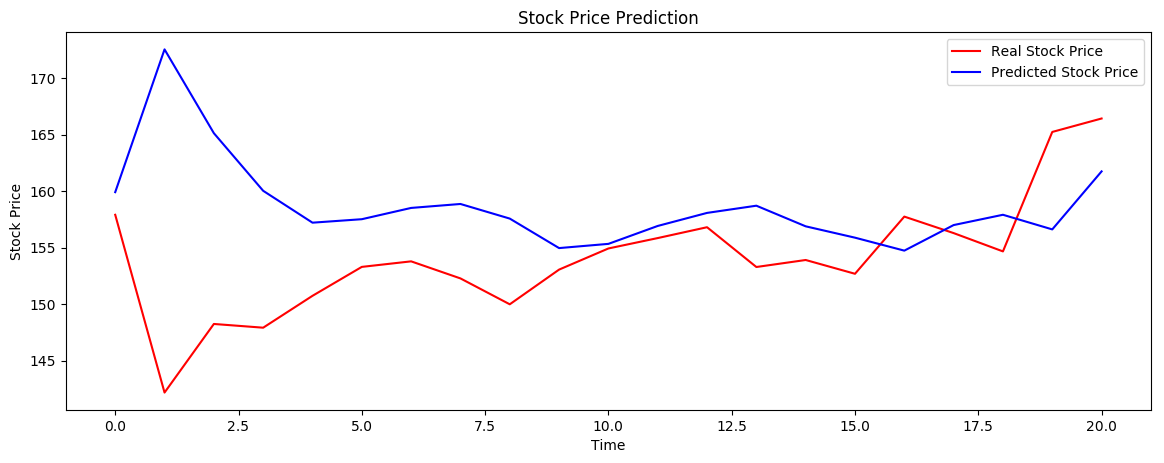

0.0585689587301
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 66.67% of the time.


(0.05856895873009995, 66.670000000000002)

In [56]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)

In [129]:
for learning_rate in [0.001, 0.002, 0.005]:
    for dropout in [0.2,0.3, 0.5]:
        model = build_rnn_model(X_train, input_features)
        print()
        print("Current model: LR={}, Dropout={}".format(
            learning_rate,dropout))
        print()
        save_best_weights = 'question_pairs_weights_lr={}_dropout={}.h5'.format(
            learning_rate,dropout)

        callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                     EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

        history = model.fit(X_train,
                            y_train,
                            batch_size=32,
                            epochs=1,
                            validation_split=0.15,
                            verbose=True,
                            shuffle=True,
                            callbacks = callbacks)

regressor model built and compiled...

Current model: LR=0.001, Dropout=0.2

Train on 1181 samples, validate on 209 samples
Epoch 1/1
1181/1181 [==============================] - 48s 40ms/step - loss: 0.0178 - val_loss: 0.0212
regressor model built and compiled...

Current model: LR=0.001, Dropout=0.3

Train on 1181 samples, validate on 209 samples
Epoch 1/1
1181/1181 [==============================] - 47s 40ms/step - loss: 0.0226 - val_loss: 0.0153
regressor model built and compiled...

Current model: LR=0.001, Dropout=0.5

Train on 1181 samples, validate on 209 samples
Epoch 1/1
1181/1181 [==============================] - 48s 41ms/step - loss: 0.0239 - val_loss: 0.0285
regressor model built and compiled...

Current model: LR=0.002, Dropout=0.2

Train on 1181 samples, validate on 209 samples
Epoch 1/1
1181/1181 [==============================] - 55s 46ms/step - loss: 0.0217 - val_loss: 0.0333
regressor model built and compiled...

Current model: LR=0.002, Dropout=0.3

Train on 1181 s

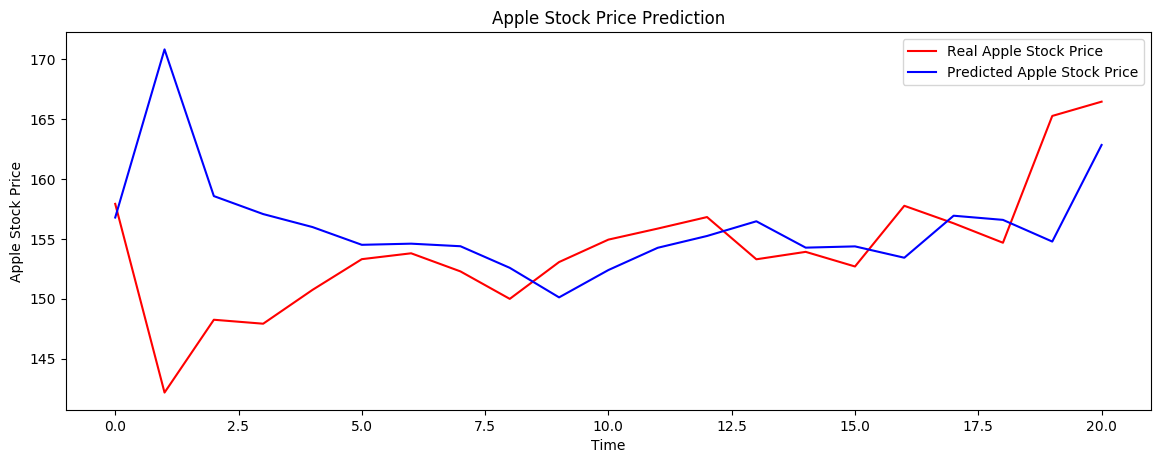

In [44]:
#Parameters ( Dropout = 0.3, Units in Layers = 120, Epochs = 90)

<br>
<br>
## IBM  STOCK ANALYSIS

In [81]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'IBM'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)

Shape of train set (1510, 7)

Train dataset head

         Date       Close     Volume         MA7        MA21        MA60  \
0  2013-01-02  196.350006  4234100.0  192.601430  192.382380  194.507167   
1  2013-01-03  195.270004  3644700.0  192.865716  192.658095  194.255167   
2  2013-01-04  193.990005  3380200.0  193.092861  192.878571  193.978501   
3  2013-01-07  193.139999  2862300.0  193.262861  193.092381  193.700500   
4  2013-01-08  192.869995  3026900.0  193.285716  193.243333  193.448500   

       MACD         EMA  
0  0.000000  196.350006  
1 -0.024231  195.540005  
2 -0.070568  194.466928  
3 -0.120602  193.571251  
4 -0.155995  193.101815  


(1510, 7)


[[ 0.82029016  0.10380173  0.79174903 ...,  0.84974444  0.63353821
   0.82602773]
 [ 0.81031139  0.08368377  0.79434236 ...,  0.84670076  0.63162254
   0.81836294]
 [ 0.79848473  0.0746556   0.79657123 ...,  0.84335916  0.6279592
   0.80820876]
 ..., 
 [ 0.0573778   0.16563358  0.00894347 ...,  0.01615848  0.38135773
   0

In [82]:
# Model Building and Training


epochs = 20
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

regressor model built and compiled...

training started...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 120, 120)          61440     
_________________________________________________________________
dropout_36 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 120, 120)          115680    
_________________________________________________________________
dropout_37 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 120, 120)          115680    
_________________________________________________________________
dropout_38 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_39 (LSTM)   

In [83]:
dataset_test = pd.read_csv(data_path_test)
print(dataset_test.head(3))

         Date       Close   Volume         MA7        MA21        MA60  \
0  2019-01-02  115.209999  4239900  112.227142  117.430000  123.551334   
1  2019-01-03  112.910004  4346700  112.508571  116.889048  122.949334   
2  2019-01-04  117.320000  4477800  113.901428  116.508571  122.431500   

       MACD         EMA  
0  0.000000  115.209999  
1 -0.051602  113.485003  
2  0.071002  116.140001  


In [84]:
# Testing the model 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA60', 'MACD', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)

         Date       Close   Volume         MA7        MA21        MA60  \
0  2019-01-02  115.209999  4239900  112.227142  117.430000  123.551334   
1  2019-01-03  112.910004  4346700  112.508571  116.889048  122.949334   
2  2019-01-04  117.320000  4477800  113.901428  116.508571  122.431500   

       MACD         EMA  
0  0.000000  115.209999  
1 -0.051602  113.485003  
2  0.071002  116.140001  

inputs

[[ 0.3452832   0.07965266  0.29995656  0.26040051  0.23952073  0.61791096
   0.33762727]
 [ 0.35923492  0.06575714  0.30919439  0.26018918  0.23660991  0.64402085
   0.34843554]
 [ 0.35415313  0.06381497  0.31806775  0.25996275  0.23602815  0.66088915
   0.34856862]
 [ 0.35008783  0.07767978  0.32371701  0.26009358  0.23557724  0.67101849
   0.34583734]
 [ 0.33188584  0.13324482  0.32513284  0.25913756  0.2352934   0.66610322
   0.33249925]
 [ 0.3414026   0.19600167  0.32531508  0.25915769  0.23502366  0.66837702
   0.33455092]
 [ 0.38501343  0.45952514  0.33166522  0.26184462  0.235

Normalized Predicted Prices
0.145484 ModeResult(mode=array([[ 0.08998804]], dtype=float32), count=array([[1]])) 0.157941
[ 0.08998804]
[ 0.09030087]
[ 0.09342493]
[ 0.10006452]
[ 0.10837708]
[ 0.11872009]
[ 0.13006309]
[ 0.14077857]
[ 0.14966984]
[ 0.15821531]
[ 0.16517684]
[ 0.16906485]
[ 0.17045221]
[ 0.17001024]
[ 0.16763364]
[ 0.16241232]
[ 0.15758225]
[ 0.15794119]
[ 0.16660935]
[ 0.18340474]
[ 0.20527139]
Normalized Real Stock Prices
0.157270896236 ModeResult(mode=array([[ 0.04933941]]), count=array([[1]])) 0.131386866912
[ 0.0705904]
[ 0.04933941]
[ 0.09008593]
[ 0.0977548]
[ 0.1132773]
[ 0.12122334]
[ 0.13138687]
[ 0.12833779]
[ 0.11845143]
[ 0.13083251]
[ 0.12981616]
[ 0.13508271]
[ 0.15014321]
[ 0.13813172]
[ 0.23394621]
[ 0.23061996]
[ 0.24392498]
[ 0.24669688]
[ 0.24725124]
[ 0.24771324]
[ 0.24808276]



Real stock prices on test data

[[ 115.209999]
 [ 112.910004]
 [ 117.32    ]
 [ 118.150002]
 [ 119.830002]
 [ 120.690002]
 [ 121.790001]
 [ 121.459999]
 [ 120.389999]
 [ 12

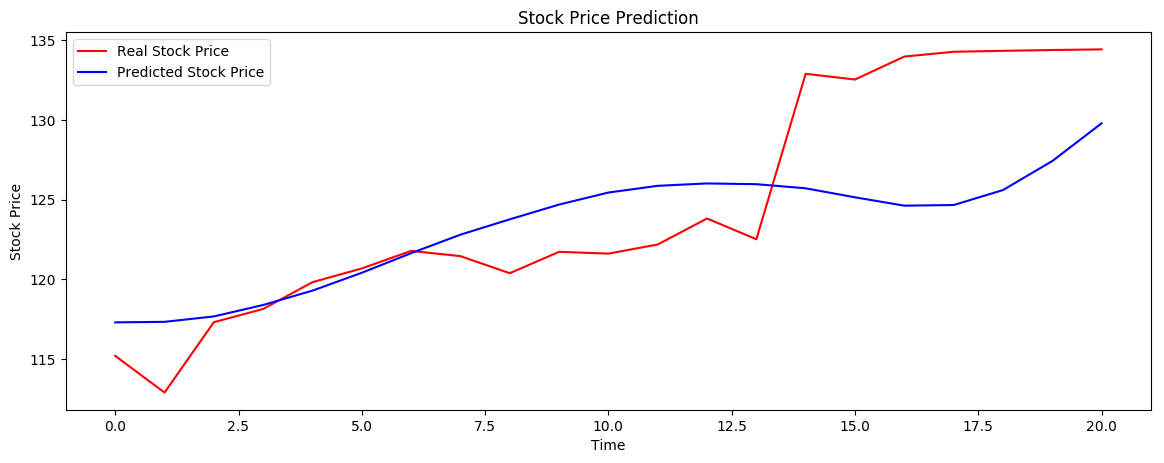

0.0400640889989
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 80.95% of the time.


In [85]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
rmse, direc = evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)

<br>
<br>
## GOLDMAN SACHS STOCK ANALYSIS 

In [93]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'GS'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)
dataset_original.head()

Shape of train set (1510, 7)

Train dataset head

         Date       Close     Volume         MA7        MA21        MA60  \
0  2013-01-02  131.660004  4449000.0  127.792858  122.880000  121.036833   
1  2013-01-03  130.940002  4584600.0  128.150001  123.477143  121.220833   
2  2013-01-04  134.509995  5234600.0  129.145714  124.330952  121.474167   
3  2013-01-07  134.259995  3556900.0  130.159998  125.146666  121.720833   
4  2013-01-08  133.050003  2760200.0  131.071428  125.901428  121.944500   

       MACD         EMA  
0  0.000000  131.660004  
1 -0.016154  131.120002  
2  0.090122  133.466920  
3  0.127224  134.002246  
4  0.096557  133.364794  


(1510, 7)


[[ 0.00505477  0.19044528  0.         ...,  0.          0.45947406
   0.00383364]
 [ 0.          0.19732297  0.00252566 ...,  0.00131401  0.45882028  0.        ]
 [ 0.02506313  0.23029129  0.0095672  ...,  0.00312316  0.46312148
   0.01666151]
 ..., 
 [ 0.24199664  0.21702281  0.26201204 ...,  0.58215967  0.0278154
   0.2

,Date,Close,Volume,MA7,MA21,MA60,MACD,EMA
0,2013-01-02,131.660004,4449000.0,127.792858,122.880000,121.036833,0.000000,131.660004
1,2013-01-03,130.940002,4584600.0,128.150001,123.477143,121.220833,-0.016154,131.120002
2,2013-01-04,134.509995,5234600.0,129.145714,124.330952,121.474167,0.090122,133.466920
3,2013-01-07,134.259995,3556900.0,130.159998,125.146666,121.720833,0.127224,134.002246
4,2013-01-08,133.050003,2760200.0,131.071428,125.901428,121.944500,0.096557,133.364794


In [94]:
# Model Building and Training


epochs = 30
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' +  str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

regressor model built and compiled...

training started...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 120, 120)          61440     
_________________________________________________________________
dropout_51 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 120, 120)          115680    
_________________________________________________________________
dropout_52 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 120, 120)          115680    
_________________________________________________________________
dropout_53 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_54 (LSTM)   

In [95]:
# Testing the model 
# Verify the columns before testing 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA60', 'MACD', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)

         Date       Close   Volume         MA7        MA21        MA60  \
0  2019-01-02  172.029999  3999400  163.835715  173.115715  199.569167   
1  2019-01-03  169.509995  4060200  165.187143  172.107143  198.632500   
2  2019-01-04  175.050003  3788300  167.858571  171.317619  197.794167   

       MACD         EMA  
0  0.000000  172.029999  
1 -0.056539  170.139996  
2  0.099754  173.539232  

inputs

[[ 0.66498175  0.0929605   0.67901881  0.72167898  0.80637963  0.36510281
   0.67317317]
 [ 0.67593371  0.07754655  0.68301946  0.71987648  0.80323624  0.38033094
   0.67922044]
 [ 0.67024712  0.09369595  0.68911136  0.71740429  0.7999524   0.39054862
   0.67740258]
 [ 0.70556022  0.13070669  0.69992118  0.71666797  0.79724701  0.41557896
   0.70060298]
 [ 0.70261163  0.43548608  0.70924593  0.71636811  0.79475467  0.43433387
   0.70634865]
 [ 0.70415614  0.27671575  0.71252929  0.71631813  0.79291815  0.45002467
   0.70930511]
 [ 0.69285314  0.20005681  0.71533782  0.7167546   0.791

Normalized Predicted Prices
0.342692 ModeResult(mode=array([[ 0.17494768]], dtype=float32), count=array([[1]])) 0.310038
[ 0.17494768]
[ 0.19149262]
[ 0.22033043]
[ 0.25970429]
[ 0.29236284]
[ 0.31003773]
[ 0.31267208]
[ 0.30497614]
[ 0.29317808]
[ 0.28348634]
[ 0.28054386]
[ 0.29196575]
[ 0.32731745]
[ 0.38613814]
[ 0.44522411]
[ 0.48018965]
[ 0.48757225]
[ 0.47893712]
[ 0.46567759]
[ 0.45570353]
[ 0.45407644]
Normalized Real Stock Prices
0.400773560714 ModeResult(mode=array([[ 0.27078062]]), count=array([[1]])) 0.463072104822
[ 0.28847231]
[ 0.27078062]
[ 0.30967425]
[ 0.31648414]
[ 0.31192075]
[ 0.31964334]
[ 0.3163437]
[ 0.32287272]
[ 0.33543947]
[ 0.34379388]
[ 0.46433585]
[ 0.47844701]
[ 0.50266772]
[ 0.46854809]
[ 0.4630721]
[ 0.46939062]
[ 0.4900309]
[ 0.48286996]
[ 0.48834595]
[ 0.50224651]
[ 0.47086487]



Real stock prices on test data

[[ 172.029999]
 [ 169.509995]
 [ 175.050003]
 [ 176.020004]
 [ 175.369995]
 [ 176.470001]
 [ 176.      ]
 [ 176.929993]
 [ 178.720001]
 [ 17

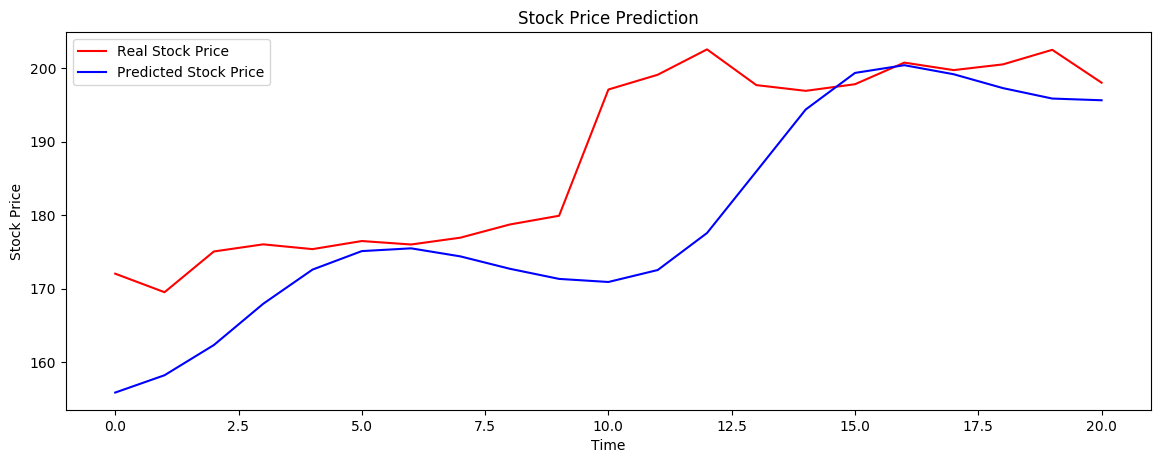

0.0631925556634
Prediction Direction [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Real Direction [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 85.71% of the time.


In [96]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
rmse, direc = evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)

<br>
<br>
## AMAZON STOCK ANALYSIS

In [13]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'AMZN'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)
dataset_original.head()

Shape of train set (1510, 7)

Train dataset head

         Date       Close     Volume         MA7        MA21        MA60  \
0  2013-01-02  257.309998  3271000.0  252.262857  253.031905  243.470001   
1  2013-01-03  258.480011  2750900.0  252.485714  253.420000  243.436834   
2  2013-01-04  259.149994  1874200.0  252.561428  253.737143  243.447501   
3  2013-01-07  268.459991  4910000.0  255.394283  254.427618  243.604167   
4  2013-01-08  266.380005  3010700.0  257.975712  255.047142  243.861167   

       MACD         EMA  
0  0.000000  257.309998  
1  0.026250  258.187508  
2  0.054224  258.853844  
3  0.401752  265.337993  
4  0.499369  266.035538  


(1510, 7)


[[  5.06900201e-03   9.56811682e-02   0.00000000e+00 ...,   1.99293176e-05
    5.69280314e-01   4.08572384e-03]
 [  5.72217348e-03   7.28327864e-02   1.27951963e-04 ...,   0.00000000e+00
    5.69461236e-01   4.57915963e-03]
 [  6.09619820e-03   3.43187000e-02   1.71422796e-04 ...,   6.40930076e-06
    5.69654038e-01   4.9

,Date,Close,Volume,MA7,MA21,MA60,MACD,EMA
0,2013-01-02,257.309998,3271000.0,252.262857,253.031905,243.470001,0.000000,257.309998
1,2013-01-03,258.480011,2750900.0,252.485714,253.420000,243.436834,0.026250,258.187508
2,2013-01-04,259.149994,1874200.0,252.561428,253.737143,243.447501,0.054224,258.853844
3,2013-01-07,268.459991,4910000.0,255.394283,254.427618,243.604167,0.401752,265.337993
4,2013-01-08,266.380005,3010700.0,257.975712,255.047142,243.861167,0.499369,266.035538


In [14]:
# Model Building and Training


epochs = 15
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' +  str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

regressor model built and compiled...

training started...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 120, 120)          61440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 120)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 120, 120)          115680    
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 120)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120, 120)          115680    
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 120)          0         
_________________________________________________________________
lstm_4 (LSTM)    

In [15]:
# Testing the model 
# Verify the columns before testing 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA60', 'MACD', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)


         Date        Close   Volume          MA7         MA21         MA60  \
0  2019-01-02  1539.130005  7983100  1453.295707  1564.700951  1640.886670   
1  2019-01-03  1500.280029  6975600  1470.842861  1555.658569  1634.397170   
2  2019-01-04  1575.390015  9182600  1503.904297  1546.279047  1629.580003   

       MACD          EMA  
0  0.000000  1539.130005  
1 -0.871634  1509.992523  
2  1.218521  1555.267710  

inputs

[[ 0.84116944  0.09299261  0.8439386   0.85015119  0.83546383  0.71902306
   0.84309886]
 [ 0.86440422  0.15110859  0.85073318  0.85286537  0.83839605  0.75079849
   0.86080688]
 [ 0.87356528  0.14454095  0.86049938  0.85586518  0.84125217  0.78264752
   0.87286128]
 [ 0.8788464   0.19211795  0.87056823  0.85860043  0.8439119   0.81037007
   0.88042572]
 [ 0.89081553  0.20163774  0.88150158  0.86214907  0.84708097  0.84113043
   0.89098457]
 [ 0.89025168  0.16557059  0.89002352  0.86545284  0.85033638  0.86157711
   0.89412555]
 [ 0.87353176  0.15744341  0.8957567

Normalized Predicted Prices
0.764624 ModeResult(mode=array([[ 0.72750872]], dtype=float32), count=array([[1]])) 0.76169
[ 0.77437294]
[ 0.76169008]
[ 0.74995476]
[ 0.74010134]
[ 0.73284143]
[ 0.72860038]
[ 0.72750872]
[ 0.72939962]
[ 0.73385233]
[ 0.74023938]
[ 0.74790663]
[ 0.75626963]
[ 0.76487726]
[ 0.77339482]
[ 0.78151304]
[ 0.78897136]
[ 0.79559678]
[ 0.80131328]
[ 0.80609101]
[ 0.80988425]
[ 0.81272131]
Normalized Real Stock Prices
0.776987619217 ModeResult(mode=array([[ 0.69896946]]), count=array([[1]])) 0.785304389602
[ 0.72065785]
[ 0.69896946]
[ 0.74090037]
[ 0.7711134]
[ 0.78622546]
[ 0.78781097]
[ 0.7860245]
[ 0.7772822]
[ 0.76424677]
[ 0.79626304]
[ 0.80141018]
[ 0.80668012]
[ 0.80834372]
[ 0.77259839]
[ 0.77698071]
[ 0.78530439]
[ 0.79403552]
[ 0.77579162]
[ 0.75122259]
[ 0.79395742]
[ 0.82092134]



Real stock prices on test data

[[ 1539.130005]
 [ 1500.280029]
 [ 1575.390015]
 [ 1629.51001 ]
 [ 1656.579956]
 [ 1659.420044]
 [ 1656.219971]
 [ 1640.560059]
 [ 1617.20996

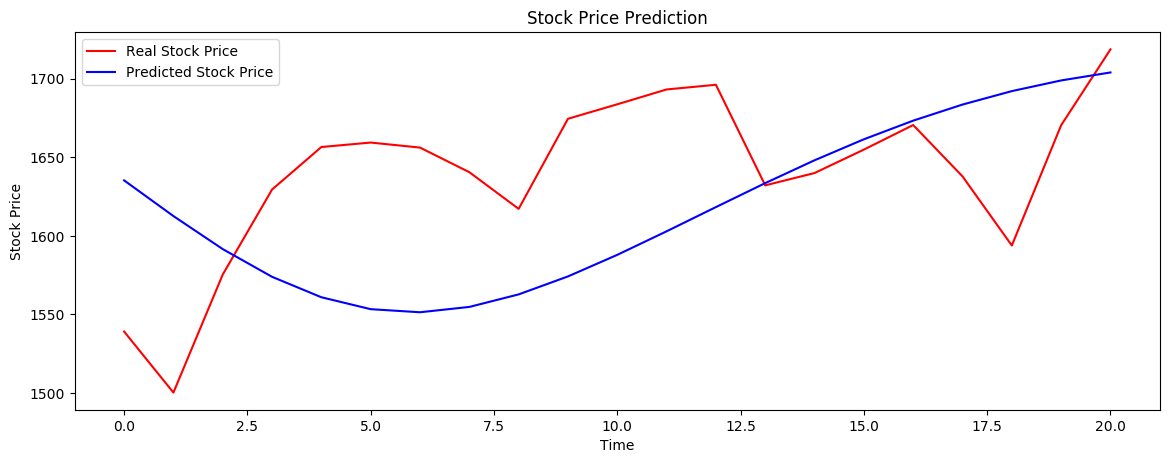

0.0447874653288
Prediction Direction [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Real Direction [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 52.38% of the time.


In [16]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
rmse, direc = evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)

<br>
<br>
## GENERAL ELECTRIC STOCK ANALYSIS

In [34]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'GE'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)
dataset_original.head()

Shape of train set (1510, 7)

Train dataset head

         Date      Close      Volume        MA7       MA21       MA42  \
0  2013-01-02  21.340000  46089500.0  20.847143  21.203334  21.049048   
1  2013-01-03  21.100000  48509100.0  20.878572  21.216667  21.043333   
2  2013-01-04  21.200001  29802600.0  20.932858  21.232857  21.040714   
3  2013-01-07  21.129999  32746700.0  20.984286  21.228095  21.034048   
4  2013-01-08  20.900000  40045500.0  21.014286  21.205714  21.017619   

       MACD        EMA  
0  0.000000  21.340000  
1 -0.005385  21.160000  
2 -0.003760  21.187693  
3 -0.005456  21.148750  
4 -0.015415  20.982231  


(1510, 7)


[[ 0.55797101  0.07874289  0.53861946 ...,  0.55371428  0.54358608
   0.55773692]
 [ 0.5488177   0.08452904  0.5398402  ...,  0.55347338  0.54123135
   0.55085455]
 [ 0.55263162  0.03979495  0.54194874 ...,  0.55336298  0.54194178
   0.55191341]
 ..., 
 [ 0.02135774  0.25496047  0.01248474 ...,  0.00740748  0.37875481
   0.01977247]
 [ 0.0305110

,Date,Close,Volume,MA7,MA21,MA42,MACD,EMA
0,2013-01-02,21.340000,46089500.0,20.847143,21.203334,21.049048,0.000000,21.340000
1,2013-01-03,21.100000,48509100.0,20.878572,21.216667,21.043333,-0.005385,21.160000
2,2013-01-04,21.200001,29802600.0,20.932858,21.232857,21.040714,-0.003760,21.187693
3,2013-01-07,21.129999,32746700.0,20.984286,21.228095,21.034048,-0.005456,21.148750
4,2013-01-08,20.900000,40045500.0,21.014286,21.205714,21.017619,-0.015415,20.982231


In [35]:
# Model Building and Training


epochs = 50
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' +  str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

regressor model built and compiled...

training started...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 120, 120)          61440     
_________________________________________________________________
dropout_26 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 120, 120)          115680    
_________________________________________________________________
dropout_27 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 120, 120)          115680    
_________________________________________________________________
dropout_28 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_29 (LSTM)   

In [36]:
# Testing the model 
# Verify the columns before testing 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA42', 'MACD', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)


         Date  Close     Volume       MA7      MA21      MA42      MACD  \
0  2019-01-02   8.05  129354100  7.408571  7.287619  7.863571  0.000000   
1  2019-01-03   8.06  122949000  7.538571  7.314286  7.815000  0.000224   
2  2019-01-04   8.23  120083800  7.725714  7.334286  7.782857  0.005558   

        EMA  
0  8.050000  
1  8.057500  
2  8.176923  

inputs

[[  2.77650648e-01   8.15565686e-02   2.62290531e-01   2.51597260e-01
    2.54594546e-01   5.48001028e-01   2.77722460e-01]
 [  2.77650648e-01   6.37609820e-02   2.65730771e-01   2.51616504e-01
    2.53982274e-01   5.56904621e-01   2.77045421e-01]
 [  2.73836766e-01   8.45204272e-02   2.68616133e-01   2.51616504e-01
    2.53159221e-01   5.60240099e-01   2.74270716e-01]
 [  2.74218154e-01   7.10204507e-02   2.71224056e-01   2.52116850e-01
    2.52346204e-01   5.63012425e-01   2.73600716e-01]
 [  2.66209001e-01   1.09883490e-01   2.70336253e-01   2.52867370e-01
    2.51001215e-01   5.57637258e-01   2.68024430e-01]
 [  2.68497330

Normalized Predicted Prices
0.301576 ModeResult(mode=array([[ 0.29998028]], dtype=float32), count=array([[1]])) 0.300827
[ 0.30071643]
[ 0.30074823]
[ 0.30110523]
[ 0.30179268]
[ 0.30264676]
[ 0.30340952]
[ 0.304151]
[ 0.30435261]
[ 0.30401209]
[ 0.30329072]
[ 0.30237231]
[ 0.30144134]
[ 0.30064672]
[ 0.30023548]
[ 0.30002245]
[ 0.29998028]
[ 0.30006418]
[ 0.30022317]
[ 0.30042675]
[ 0.30063152]
[ 0.30082732]
Normalized Real Stock Prices
0.0805274054702 ModeResult(mode=array([[ 0.07704043]]), count=array([[2]])) 0.08352402746
[ 0.05110603]
[ 0.05148741]
[ 0.05797101]
[ 0.07742182]
[ 0.07055683]
[ 0.0682685]
[ 0.08504958]
[ 0.08504958]
[ 0.08352403]
[ 0.07704043]
[ 0.08657513]
[ 0.09267735]
[ 0.08962624]
[ 0.07437071]
[ 0.07704043]
[ 0.07894737]
[ 0.09344012]
[ 0.08466819]
[ 0.08352403]
[ 0.09115179]
[ 0.13157895]



Real stock prices on test data

[[  8.05]
 [  8.06]
 [  8.23]
 [  8.74]
 [  8.56]
 [  8.5 ]
 [  8.94]
 [  8.94]
 [  8.9 ]
 [  8.73]
 [  8.98]
 [  9.14]
 [  9.06]
 [  8.66]


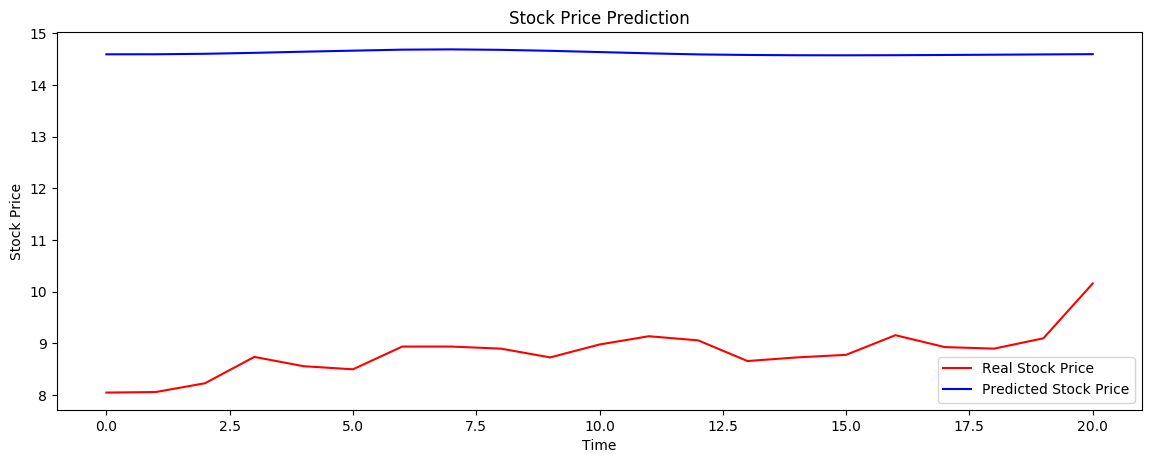

0.658892774872
Prediction Direction [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Real Direction [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 100.0% of the time.


In [37]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
rmse, direc = evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)

<br>
<br>
## GOOGLE STOCK ANALYSIS

In [52]:
# Give the training dataset path and the columns to be extracted from it 
symbol = 'GOOG'
data_path = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators.csv"
columns_list = [1,2,3,4,5,6,7]

X_train, y_train, sc, sc_close, dataset_original = data_load_prepare(data_path, columns_list)
dataset_original.head()

Shape of train set (1510, 7)

Train dataset head

         Date       Close     Volume         MA7        MA21        MA60  \
0  2013-01-02  359.288177  5115500.0  352.771990  349.848621  346.310086   
1  2013-01-03  359.496826  4666500.0  353.342564  350.520916  345.942642   
2  2013-01-04  366.600616  5562800.0  355.362993  351.631313  345.696907   
3  2013-01-07  365.001007  3332900.0  357.199615  352.741472  345.505734   
4  2013-01-08  364.280701  3373900.0  359.116433  353.739031  345.416398   

         MA42         EMA  
0  341.370073  359.288177  
1  341.796821  359.444664  
2  342.388804  364.398785  
3  343.001367  364.805285  
4  343.611447  364.454117  


(1510, 7)


[[  1.10144912e-02   2.19443872e-01   0.00000000e+00 ...,   1.99206678e-03
    0.00000000e+00   1.02243757e-02]
 [  1.12414894e-02   2.00152952e-01   6.43468295e-04 ...,   1.56485174e-03
    4.88096025e-04   1.03957198e-02]
 [  1.89700070e-02   2.38661752e-01   2.92201970e-03 ...,   1.27914303e-03
    1.165180

,Date,Close,Volume,MA7,MA21,MA60,MA42,EMA
0,2013-01-02,359.288177,5115500.0,352.771990,349.848621,346.310086,341.370073,359.288177
1,2013-01-03,359.496826,4666500.0,353.342564,350.520916,345.942642,341.796821,359.444664
2,2013-01-04,366.600616,5562800.0,355.362993,351.631313,345.696907,342.388804,364.398785
3,2013-01-07,365.001007,3332900.0,357.199615,352.741472,345.505734,343.001367,364.805285
4,2013-01-08,364.280701,3373900.0,359.116433,353.739031,345.416398,343.611447,364.454117


In [53]:
# Model Building and Training


epochs = 80
input_features = 7
no_timesteps = 120 
#build the model
regressor = build_rnn_model(X_train, input_features)

#train the model
regressor_trained = train_model(regressor, X_train, y_train, epochs)

# Save the weights
regressor.save_weights('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' + str(symbol) + '_model_weights.h5')

# Save the model architecture
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/' +  str(symbol) + '_model_architecture.json', 'w') as f:
    f.write(regressor.to_json())

regressor model built and compiled...

training started...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 120, 120)          61440     
_________________________________________________________________
dropout_46 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 120, 120)          115680    
_________________________________________________________________
dropout_47 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 120, 120)          115680    
_________________________________________________________________
dropout_48 (Dropout)         (None, 120, 120)          0         
_________________________________________________________________
lstm_49 (LSTM)   

Epoch 59/80
1181/1181 [==============================] - 39s 33ms/step - loss: 6.9690e-04 - val_loss: 0.0015
Epoch 60/80
1181/1181 [==============================] - 39s 33ms/step - loss: 6.6681e-04 - val_loss: 0.0015
Epoch 61/80
1181/1181 [==============================] - 38s 32ms/step - loss: 6.5994e-04 - val_loss: 0.0011
Epoch 62/80
1181/1181 [==============================] - 39s 33ms/step - loss: 6.1592e-04 - val_loss: 0.0016
Epoch 63/80
1181/1181 [==============================] - 42s 35ms/step - loss: 6.9032e-04 - val_loss: 0.0010
Epoch 64/80
1181/1181 [==============================] - 39s 33ms/step - loss: 7.1199e-04 - val_loss: 0.0015
Epoch 65/80
1181/1181 [==============================] - 40s 34ms/step - loss: 7.1588e-04 - val_loss: 0.0021
Epoch 66/80
1181/1181 [==============================] - 40s 34ms/step - loss: 6.7309e-04 - val_loss: 0.0020
Epoch 67/80
1181/1181 [==============================] - 41s 34ms/step - loss: 6.8145e-04 - val_loss: 0.0015
Epoch 68/80
1181/11

In [54]:
# Testing the model 
# Verify the columns before testing 

data_path_test = "/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/" + str(symbol) + "_indicators_test.csv"
columns = ['Close', 'Volume', 'MA7', 'MA21', 'MA42', 'MA60', 'EMA']

real_stock_price, predicted_stock_price, dir_test, dir_pred = test_model(regressor_trained, data_path_test, dataset_original, columns, sc, sc_close, no_timesteps)


         Date        Close   Volume          MA7         MA21         MA60  \
0  2019-01-02  1045.849976  1532600  1022.519976  1040.536662  1062.021994   
1  2019-01-03  1016.059998  1841100  1027.737122  1036.804754  1059.667161   
2  2019-01-04  1070.709961  2093900  1041.235692  1035.103798  1058.362828   

          MA42          EMA  
0  1047.929051  1045.849976  
1  1046.483574  1023.507493  
2  1046.500478  1056.186125  

inputs

[[ 0.87550677  0.04778047  0.88386693  0.89717191  0.89896739  0.86526168
   0.87919612]
 [ 0.90768807  0.05344745  0.8928922   0.89956021  0.9013265   0.8673456
   0.90151056]
 [ 0.91349765  0.05215852  0.9067362   0.9024823   0.90377973  0.86957097
   0.91284668]
 [ 0.9081015   0.04501787  0.91633662  0.90419888  0.90667616  0.87140403
   0.9130048 ]
 [ 0.92435543  0.06885011  0.92578238  0.9067159   0.90991585  0.87380287
   0.92396319]
 [ 0.92117859  0.05953547  0.93252153  0.90792844  0.91316275  0.87625108
   0.92548447]
 [ 0.9114741   0.05451296

Normalized Predicted Prices
0.839175 ModeResult(mode=array([[ 0.8179366]], dtype=float32), count=array([[1]])) 0.841459
[ 0.82135183]
[ 0.82541007]
[ 0.8179366]
[ 0.82005268]
[ 0.82710582]
[ 0.83540672]
[ 0.84145921]
[ 0.84352362]
[ 0.83946532]
[ 0.8305946]
[ 0.83092779]
[ 0.83791858]
[ 0.8478778]
[ 0.85771066]
[ 0.8570798]
[ 0.85272938]
[ 0.84832639]
[ 0.84989572]
[ 0.84875196]
[ 0.84356743]
[ 0.84558374]
Normalized Real Stock Prices
0.786691747817 ModeResult(mode=array([[ 0.7255447]]), count=array([[1]])) 0.788471344593
[ 0.7579545]
[ 0.7255447]
[ 0.78500074]
[ 0.78247677]
[ 0.79106065]
[ 0.78929819]
[ 0.78458731]
[ 0.77029173]
[ 0.75669244]
[ 0.79200716]
[ 0.79616304]
[ 0.80587843]
[ 0.81497362]
[ 0.78479409]
[ 0.79028812]
[ 0.78847134]
[ 0.80706425]
[ 0.78431533]
[ 0.77402343]
[ 0.8049646]
[ 0.83467625]



Real stock prices on test data

[[ 1045.849976]
 [ 1016.059998]
 [ 1070.709961]
 [ 1068.390015]
 [ 1076.280029]
 [ 1074.660034]
 [ 1070.329956]
 [ 1057.189941]
 [ 1044.689941]
 [

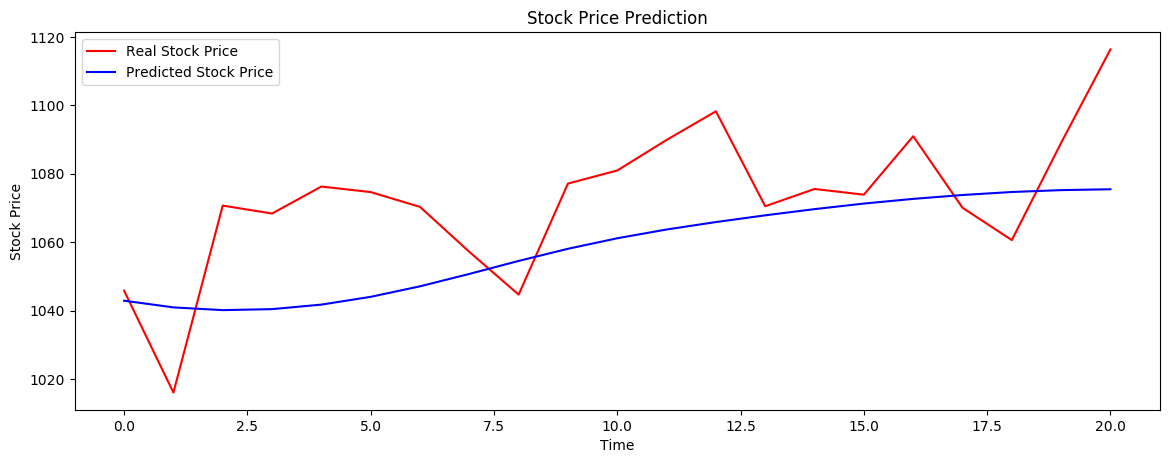

0.020448544494
Prediction Direction [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Real Direction [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predicted values matched the actual direction 95.24000000000001% of the time.


In [51]:
# Visualizing and evaluating

visualize_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)
rmse, direc = evaluate_model(real_stock_price, predicted_stock_price, dir_test, dir_pred)